## Trials for the implementation of ViT

Before coding the actual ViT, we want to make some trials in order to understand how we should treat the data and obtain the desired outcome.
Let's start, as usual by doing the imports and importing the data.

We are resizing the images to 224 x 224 according to what is written in the ViT paper.

In [9]:
import torch, torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
import utils, engine, data_setup

import os
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = Path('../datasets/PizzaSushiSteak')
train_path = data_path / 'train'
test_path = data_path / 'test'

IMG_SIZE = 224

simple_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# batch size is 32 because of the limitation of the hardware available
batch_size = 32

train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(train_path, test_path, simple_transform, batch_size)

### Visualization of the image

Now let us pick an image from the dataset and visualize it. We are going to use that image for the trials in the problem we are tackling

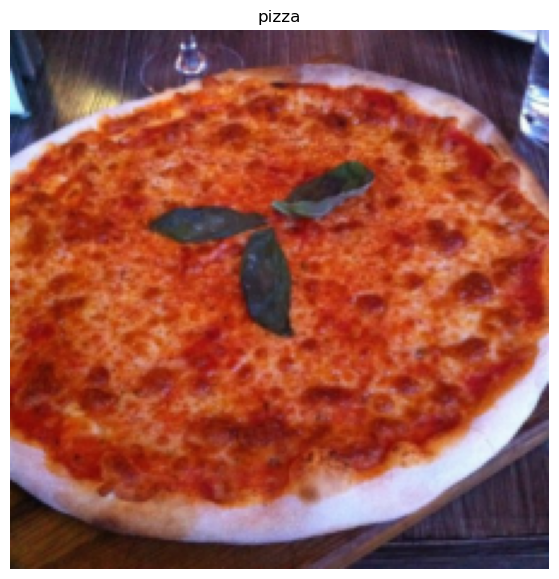

In [15]:
image_batch, image_labels = next(iter(train_dataloader))

image, label = image_batch[0], image_labels[0]

plt.figure(figsize=(10,7))
plt.imshow(image.permute(1,2,0))
plt.title(classes[label])
plt.axis(False) ;

Let us look first what's the size of the image we are considering

In [16]:
image.shape

torch.Size([3, 224, 224])

## Patchification of the image

Once we have our image, the first step to consider is dividing the image into patches.
We are going to implement the Base Version of the ViT that performs better with patches of size 16 x 16.
For this reason, we are going to come up with $ \frac{224}{16} = 14 $ patches in each row and column, for a total of $ 14 \cdot 14 = 196 $ patches.

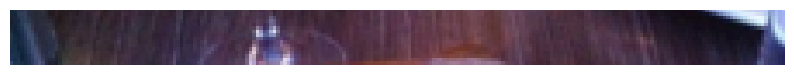

In [17]:
image_permuted = image.permute(1,2,0)

patch_size = 16

plt.figure(figsize=(10,7))
plt.axis(False)
plt.imshow(image_permuted[:patch_size, :, :])

Numebr of patches per row and per column: 14


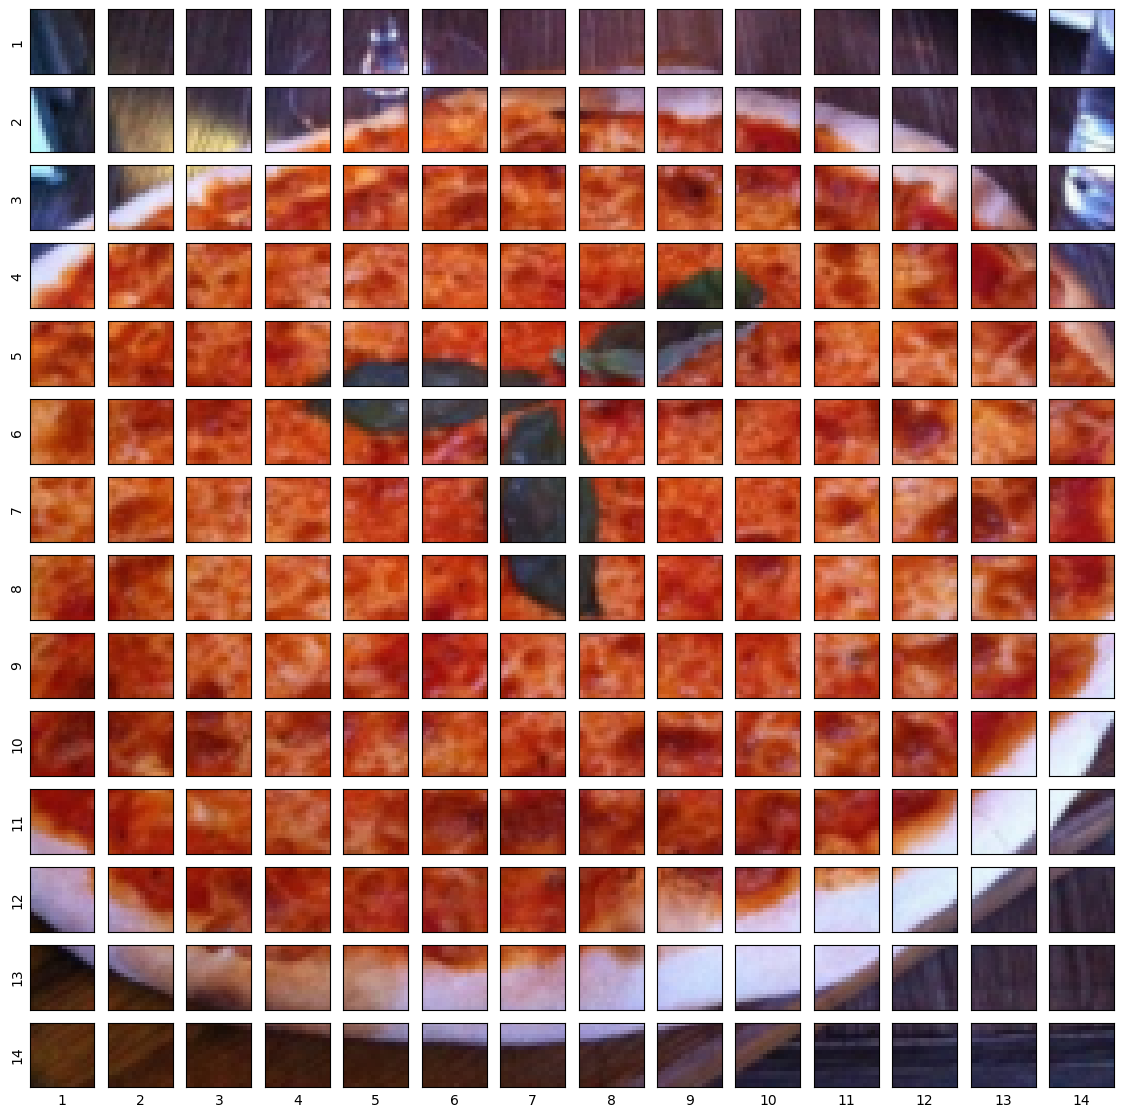

In [25]:
img_size = 224
patch_size = 16
num_patches = 224 // 16

assert img_size % patch_size == 0, 'Image size must be divisible for the patch size'
print(f'Numebr of patches per row and per column: {num_patches}')

fig, axs = plt.subplots(nrows=num_patches,
             ncols=num_patches,
             figsize=(num_patches, num_patches),
             sharex=True,
             sharey=True)

for i, row_pixel in enumerate(range(0, img_size, patch_size)):
    for j, col_pixel in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[row_pixel : row_pixel + patch_size,
                               col_pixel : col_pixel + patch_size,
                               :])
        axs[i, j].set_ylabel(i+1)
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

plt.show()

## Patchification of the Images in pytorch

Now that we have seen what we are expecting, we need to patchify the image in Pytorch.
Instead of doing the patchification by splitting the image we can use the "Hybrid approach" involving CNNs as described in the paper.

In input we have $ H \cdot W \cdot C $ and in output we have $ N \cdot (P^2 \cdot C) $ where P is the size of the patch, N is the number of patches and C is the color channels.
Therefore, since the size of the patch is 16, we will have $ 16 \times 16 \times  3 = 768 $ output channels. Instead $ N = 14 \times 14 = 196 $.

The desired shape will be (196, 768).

In [27]:
out_dim = patch_size * patch_size * 3

patchifier = nn.Conv2d(in_channels=3,out_channels=out_dim, kernel_size=patch_size, stride=patch_size, padding=0)

image_after_conv = patchifier(torch.unsqueeze(image, 0))
image_after_conv.shape

torch.Size([1, 768, 14, 14])

And visualize some of the filters.

Unsqueezed image shape: torch.Size([768, 14, 14])
Random feature maps being plotted:[414, 665, 140, 10, 753]


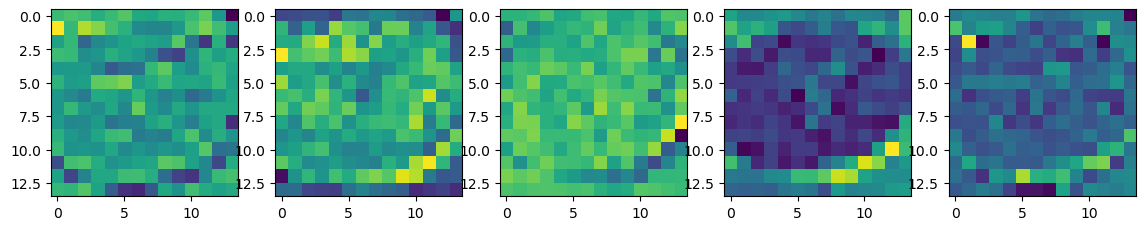

In [38]:
import random

random_idx = random.choices(range(0,768), k=5)

fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(14,14))

unsqueezed_image = torch.squeeze(image_after_conv)
print(f'Unsqueezed image shape: {unsqueezed_image.shape}')
print(f'Random feature maps being plotted:{random_idx}')

for i, idx in enumerate(random_idx):
    axs[i].imshow(unsqueezed_image[idx, :, :].detach().numpy())

The good thing about using a Convolutional layer, is that the weights can be learned as the model is trained.

### Flattening the result

Once we're done with the pre-processing and patchification of the image, we would like to get something of the shape (196, 768) as mentioned earlier and for now we have

In [40]:
torch.squeeze(image_after_conv).shape

torch.Size([768, 14, 14])

In order to do so, we need to flatten the last 2 layers in such a way to get something like (768, 196).
This can be easily be achieved with an nn.Flatten() layer. We need to flatten the last 2 dimensions.

In [42]:
flatten_layer = nn.Flatten(start_dim=-2, end_dim=-1)

flattened_image = flatten_layer(image_after_conv)
flattened_image.shape

torch.Size([1, 768, 196])

Great!

However, we wanted something like (196, 768). For this reason, we need to permute the result

In [43]:
pre_processed_image = flattened_image.permute(0, 2, 1)
pre_processed_image.shape

torch.Size([1, 196, 768])

And we are done!

If we want to plot a single feature map of the pre processed data we can do as follows:

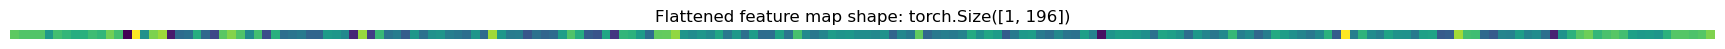

In [45]:
single_feature_map = pre_processed_image[:,:,0]

plt.figure(figsize=(22,22))
plt.imshow(single_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_feature_map.shape}')
plt.axis(False) ;

We have obtained now a 1D version of the image that we can feed into the transformer as if it was a text sequence.

# Turn everything into a layer

To have a faster and more understandable execution, we are going to merge together all these operations in one layer

In [46]:
class PatchEmbeddingLayer(nn.Module):

    def __init__(self,
                 in_channels:int,
                 embedding_dimension:int,
                 patch_size:int):
        super().__init__()

        self.convolutional_layer = nn.Conv2d(in_channels=in_channels,
                                             out_channels=embedding_dimension,
                                             kernel_size=patch_size,
                                             stride=patch_size,
                                             padding=0)

        self.flatten_layer = nn.Flatten(start_dim=-2, end_dim=-1)

    def forward(self,x):
        patched = self.convolutional_layer(x)
        flattned = self.flatten_layer(patched)
        return flattned.permute(0,2,1)

In [47]:
utils.set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbeddingLayer(in_channels=3,
                              patch_size=16,
                              embedding_dimension=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### Prepending the CLS token

Following the idea used in the BeRT paper, the writers of the ViT paper decided to add a CLS token at the beginning of the sequence that will be considered after the processing of the sequence in order to perform the classification.

So before all the 196 embeddings of each patch, we want to attach a learnable CLS token (that will have, of course, size 768 in order to match the size of the rest of the tensor).

In [51]:
cls_token = nn.Parameter(torch.ones((1, 1, 768), requires_grad=True)) # (batch_size, 1, 768)
cls_token_image = torch.cat([cls_token, patch_embedded_image], dim=1)
cls_token_image.shape, cls_token_image

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2455,  0.0416, -0.0913,  ...,  0.2043, -0.1243,  0.0235],
          [-0.2640,  0.0174, -0.0999,  ...,  0.1755, -0.0839,  0.0997],
          ...,
          [-0.1901,  0.0495, -0.0453,  ...,  0.1363, -0.0907, -0.0061],
          [-0.1811, -0.0069, -0.0609,  ...,  0.1673, -0.1120,  0.0244],
          [-0.1489,  0.0369, -0.1021,  ...,  0.1780, -0.0257,  0.0634]]],
        grad_fn=<CatBackward0>))

### Position Embedding

Following the formula on the paper, we need to add the learnable positional embeddings to the patchified version of the image.

In [53]:
pos_emb = nn.Parameter(torch.ones((1, 197, 768)), requires_grad=True)
pos_token_image = pos_emb + cls_token_image
pos_token_image

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7545, 1.0416, 0.9087,  ..., 1.2043, 0.8757, 1.0235],
         [0.7360, 1.0174, 0.9001,  ..., 1.1755, 0.9161, 1.0997],
         ...,
         [0.8099, 1.0495, 0.9547,  ..., 1.1363, 0.9093, 0.9939],
         [0.8189, 0.9931, 0.9391,  ..., 1.1673, 0.8880, 1.0244],
         [0.8511, 1.0369, 0.8979,  ..., 1.1780, 0.9743, 1.0634]]],
       grad_fn=<AddBackward0>)

Of course in the actual implementation we are going to use some randomly initialized weights for better generalization.


***

## Transformer architecture
### Multihead attention

Once our input is ready to be processed, we need to make it go through the network architecture that was reported on the Vit paper.
We have first:
- Layer norm
- Multi head self-attention
- Residual connection

The layer normalization will be performed on the last dimension. Layer normalization is used to normalize the features of each input patch.

In [54]:
input_image = pos_token_image

layer_norm = nn.LayerNorm(normalized_shape=768)

layer_norm_image = layer_norm(input_image)
layer_norm_image

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.9439,  0.3466, -0.7139,  ...,  1.6443, -0.9767,  0.2022],
         [-2.1406,  0.1523, -0.8030,  ...,  1.4407, -0.6728,  0.8233],
         ...,
         [-1.6157,  0.4164, -0.3877,  ...,  1.1529, -0.7727, -0.0550],
         [-1.4211, -0.0514, -0.4766,  ...,  1.3175, -0.8784,  0.1945],
         [-1.2065,  0.3148, -0.8233,  ...,  1.4702, -0.1980,  0.5316]]],
       grad_fn=<NativeLayerNormBackward0>)

And now we want to make it go through a Multi-head self attention layer. Luckily, this layer is already available in pytorch.
From Table 1 in the paper, we see that ViT-Base uses 12 heads.

In [58]:
# We need embed dim = 768 to make the residual connection work
msa_layer = nn.MultiheadAttention(embed_dim=768, num_heads=12,batch_first=True)
attn_image, _ = msa_layer(layer_norm_image,layer_norm_image,layer_norm_image, need_weights=False)
attn_image.shape, attn_image

(torch.Size([1, 197, 768]),
 tensor([[[ 0.0795, -0.1085,  0.0637,  ..., -0.0613, -0.0971, -0.5439],
          [ 0.0726, -0.1110,  0.0568,  ..., -0.0431, -0.0906, -0.5488],
          [ 0.0758, -0.1085,  0.0590,  ..., -0.0459, -0.0898, -0.5507],
          ...,
          [ 0.0759, -0.1059,  0.0563,  ..., -0.0538, -0.0898, -0.5528],
          [ 0.0769, -0.1101,  0.0555,  ..., -0.0462, -0.0934, -0.5512],
          [ 0.0765, -0.1071,  0.0525,  ..., -0.0455, -0.0967, -0.5541]]],
        grad_fn=<TransposeBackward0>))

And finally, we make the residual connection work.

In [59]:
image_res_conn = attn_image + input_image
image_res_conn

tensor([[[2.0795, 1.8915, 2.0637,  ..., 1.9387, 1.9029, 1.4561],
         [0.8271, 0.9307, 0.9655,  ..., 1.1612, 0.7852, 0.4747],
         [0.8118, 0.9089, 0.9592,  ..., 1.1296, 0.8263, 0.5490],
         ...,
         [0.8858, 0.9436, 1.0110,  ..., 1.0824, 0.8195, 0.4411],
         [0.8958, 0.8830, 0.9946,  ..., 1.1211, 0.7945, 0.4733],
         [0.9277, 0.9299, 0.9505,  ..., 1.1326, 0.8775, 0.5093]]],
       grad_fn=<AddBackward0>)

Now we need to take the second part of the transformer, made up of the following layers:
- Layer norm
- MLP

The layer norm works in the same way as before

In [61]:
layer_norm_1 = nn.LayerNorm(normalized_shape=768)

layer_norm_image_1 = layer_norm_1(image_res_conn)
layer_norm_image_1

tensor([[[ 0.1935, -0.3228,  0.1501,  ..., -0.1932, -0.2915, -1.5190],
         [-0.4676, -0.1994, -0.1093,  ...,  0.3979, -0.5763, -1.3806],
         [-0.5100, -0.2578, -0.1273,  ...,  0.3152, -0.4723, -1.1925],
         ...,
         [-0.3218, -0.1715,  0.0037,  ...,  0.1896, -0.4942, -1.4786],
         [-0.2928, -0.3257, -0.0372,  ...,  0.2899, -0.5546, -1.3856],
         [-0.2084, -0.2026, -0.1490,  ...,  0.3252, -0.3389, -1.2976]]],
       grad_fn=<NativeLayerNormBackward0>)

And for what concerns the MLP block we have the following:
2 MLP layers with GELU activation function, each of size 3072 according to Table 1 for ViT-Base.
We can also notice in appendix B that there is a Dropout of 0.1

In [62]:
class MLPBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=768, out_features=3072)
        self.dropout = nn.Dropout(p=0.1)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(in_features=3072, out_features=768)

    def forward(self,x):
        lin = self.linear1(x)
        gelu_act = self.activation(lin)
        drop1 = self.dropout(gelu_act)
        lin = self.linear2(drop1)
        drop2 = self.dropout(lin)
        return drop2

mlp_layer = MLPBlock()
mlp_output = mlp_layer(layer_norm_image_1)

mlp_output.shape, mlp_output

(torch.Size([1, 197, 768]),
 tensor([[[-0.0078, -0.2169, -0.0269,  ..., -0.0000,  0.1954, -0.0038],
          [ 0.0231,  0.1064, -0.2160,  ..., -0.3508,  0.2649,  0.0615],
          [ 0.0318,  0.1797, -0.0917,  ..., -0.2856,  0.2564, -0.1182],
          ...,
          [ 0.0615,  0.2062, -0.0705,  ..., -0.3767,  0.3148,  0.0000],
          [ 0.0274,  0.2441, -0.1470,  ..., -0.0000,  0.2417, -0.0375],
          [ 0.0000,  0.1998, -0.0472,  ..., -0.3561,  0.0711,  0.0171]]],
        grad_fn=<MulBackward0>))